## Notebook to retrieve IWP from GMI TB and other auxiliary data using QRNN

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import ipywidgets as w
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from torch.utils.data import DataLoader, random_split
from iwc2tb.GMI.gmiData2 import gmiData
import os

from typhon.retrieval.qrnn import set_backend, QRNN
set_backend("pytorch")
import time

##### set hyperparameters

In [2]:
#time.sleep(60 * 60)
#quantiles         = np.array([0.002, 0.03, 0.10, 0.16, 0.25, 0.34, 0.5, 0.66, 0.75, 0.84, 0.90, 0.97, 0.998])

quantiles         = np.arange(0.05, 1, 0.05)
quantiles         = np.linspace(0.01, 0.99, 128)
print(quantiles)
batchSize         = 256

depth             = 5
width             = 256 # 512
convergence_epoch = 5
maximum_epoch     = 80

inputs            = np.array(["ta", "t2m",  "wvp", "z0", "stype"])
#inputs            = np.array(["ta", "t2m",  "wvp", "lat"])
#inputs            = np.array(["ta", "t2m", "wvp", "lat", "stype"])
ninputs           = len(inputs) + 3 + 10

outputs           = "iwp"

inChannels = np.array(['166.5V', '166.5H', '183+-7', '183+-3'], dtype=object)


#latlims           = [45, 65] 
latlims           = [0, 65]
xlog              = True

outputfile        = os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_random1.nc")

[0.01       0.01771654 0.02543307 0.03314961 0.04086614 0.04858268
 0.05629921 0.06401575 0.07173228 0.07944882 0.08716535 0.09488189
 0.10259843 0.11031496 0.1180315  0.12574803 0.13346457 0.1411811
 0.14889764 0.15661417 0.16433071 0.17204724 0.17976378 0.18748031
 0.19519685 0.20291339 0.21062992 0.21834646 0.22606299 0.23377953
 0.24149606 0.2492126  0.25692913 0.26464567 0.2723622  0.28007874
 0.28779528 0.29551181 0.30322835 0.31094488 0.31866142 0.32637795
 0.33409449 0.34181102 0.34952756 0.35724409 0.36496063 0.37267717
 0.3803937  0.38811024 0.39582677 0.40354331 0.41125984 0.41897638
 0.42669291 0.43440945 0.44212598 0.44984252 0.45755906 0.46527559
 0.47299213 0.48070866 0.4884252  0.49614173 0.50385827 0.5115748
 0.51929134 0.52700787 0.53472441 0.54244094 0.55015748 0.55787402
 0.56559055 0.57330709 0.58102362 0.58874016 0.59645669 0.60417323
 0.61188976 0.6196063  0.62732283 0.63503937 0.64275591 0.65047244
 0.65818898 0.66590551 0.67362205 0.68133858 0.68905512 0.696771

## training

In [3]:
def train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data):
        qrnn = QRNN(ninputs, quantiles, (depth, width , "relu"))
        for lr in [  0.01, 0.001, 0.0001]:
            print ("NEW LEARNING RATE")
            results = qrnn.train(
                training_data,
                validation_data,
                batch_size=batchSize,
                momentum = 0.9,
                sigma_noise=None,
                initial_learning_rate= lr ,
                maximum_epochs=maximum_epoch,
                convergence_epochs= convergence_epoch,    
                gpu=True)

        return results, qrnn



In [4]:
ninputs

18

### read training data

In [5]:
data = gmiData(os.path.expanduser("~/Dendrite/Projects/IWP/GMI/training_data/TB_GMI_train.nc"), 
               inputs, outputs, latlims = latlims,
               batch_size = batchSize, log_iwp = xlog)  

n = len(data)
n_train = int(0.9 * n)
n_val = n - n_train

training_data, validation_data = random_split(data, [n_train, n_val])
results = []

print(len(validation_data))

625


### start training

In [6]:
results, qrnn = train(depth, width, batchSize, convergence_epoch, maximum_epoch, training_data, validation_data)


NEW LEARNING RATE
1260825.4569978714 1437544 5616, Training error: 0.877
Epoch 0 / 80: Training error: 0.877, Validation error: 0.785, Learning rate: 0.01000
1111974.728149891 1437544/ 5616, Training error: 0.774
Epoch 1 / 80: Training error: 0.774, Validation error: 0.756, Learning rate: 0.01000
1091378.3866300583 1437544 5616, Training error: 0.759
Epoch 2 / 80: Training error: 0.759, Validation error: 0.744, Learning rate: 0.01000
1081161.7294168472 1437544 5616, Training error: 0.752
Epoch 3 / 80: Training error: 0.752, Validation error: 0.745, Learning rate: 0.01000
1068944.9360675812 1437544 5616, Training error: 0.744
Epoch 4 / 80: Training error: 0.744, Validation error: 0.756, Learning rate: 0.01000
1063160.8144769669 1437544 5616, Training error: 0.740
Epoch 5 / 80: Training error: 0.740, Validation error: 0.727, Learning rate: 0.01000
1058162.560040474 1437544/ 5616, Training error: 0.736
Epoch 6 / 80: Training error: 0.736, Validation error: 0.734, Learning rate: 0.01000
10

1010941.6544857025 1437544/ 5616, Training error: 0.703
Epoch 58 / 80: Training error: 0.703, Validation error: 0.704, Learning rate: 0.00063
1013103.5645246506 1437544/ 5616, Training error: 0.705
Epoch 59 / 80: Training error: 0.705, Validation error: 0.704, Learning rate: 0.00063
1012371.6988973618 1437544/ 5616, Training error: 0.704
Epoch 60 / 80: Training error: 0.704, Validation error: 0.704, Learning rate: 0.00063
1012065.8672919273 1437544/ 5616, Training error: 0.704
Epoch 61 / 80: Training error: 0.704, Validation error: 0.705, Learning rate: 0.00063
1011408.2230095863 1437544/ 5616, Training error: 0.704
Epoch 62 / 80: Training error: 0.704, Validation error: 0.705, Learning rate: 0.00063
1012705.5045371056 1437544/ 5616, Training error: 0.704
Epoch 63 / 80: Training error: 0.704, Validation error: 0.703, Learning rate: 0.00063
1012458.7979836464 1437544/ 5616, Training error: 0.704
Epoch 64 / 80: Training error: 0.704, Validation error: 0.703, Learning rate: 0.00063
101206

1010220.8438272476 1437544/ 5616, Training error: 0.703
Epoch 36 / 80: Training error: 0.703, Validation error: 0.704, Learning rate: 0.00006
1009768.1983580589 1437544/ 5616, Training error: 0.702
Epoch 37 / 80: Training error: 0.702, Validation error: 0.702, Learning rate: 0.00006
1010428.7033305168 1437544/ 5616, Training error: 0.703
Epoch 38 / 80: Training error: 0.703, Validation error: 0.703, Learning rate: 0.00003
1010454.5255308151 1437544/ 5616, Training error: 0.703
Epoch 39 / 80: Training error: 0.703, Validation error: 0.700, Learning rate: 0.00003
1010511.5723748207 1437544/ 5616, Training error: 0.703
Epoch 40 / 80: Training error: 0.703, Validation error: 0.703, Learning rate: 0.00003
1009298.3112649918 1437544/ 5616, Training error: 0.702
Epoch 41 / 80: Training error: 0.702, Validation error: 0.704, Learning rate: 0.00003
1010049.2022027969 1437544/ 5616, Training error: 0.703
Epoch 42 / 80: Training error: 0.703, Validation error: 0.705, Learning rate: 0.00003
100997

1009663.906472683 1437544 / 5616, Training error: 0.702
Epoch 14 / 80: Training error: 0.702, Validation error: 0.705, Learning rate: 0.00005
1010157.7288150787 1437544/ 5616, Training error: 0.703
Epoch 15 / 80: Training error: 0.703, Validation error: 0.704, Learning rate: 0.00005
1010605.4463410378 1437544/ 5616, Training error: 0.703
Epoch 16 / 80: Training error: 0.703, Validation error: 0.703, Learning rate: 0.00005
1009496.5770664215 1437544/ 5616, Training error: 0.702
Epoch 17 / 80: Training error: 0.702, Validation error: 0.702, Learning rate: 0.00003
1009681.8109612465 1437544/ 5616, Training error: 0.702
Epoch 18 / 80: Training error: 0.702, Validation error: 0.705, Learning rate: 0.00003
1010100.4718852043 1437544/ 5616, Training error: 0.703
Epoch 19 / 80: Training error: 0.703, Validation error: 0.704, Learning rate: 0.00003
1009865.97600317 14375445 / 5616, Training error: 0.702
Epoch 20 / 80: Training error: 0.702, Validation error: 0.701, Learning rate: 0.00003
100939

1011173.7300477028 1437544/ 5616, Training error: 0.703
Epoch 72 / 80: Training error: 0.703, Validation error: 0.702, Learning rate: 0.00000
1009725.2113199234 1437544/ 5616, Training error: 0.702
Epoch 73 / 80: Training error: 0.702, Validation error: 0.703, Learning rate: 0.00000
1009743.9609694481 1437544/ 5616, Training error: 0.702
Epoch 74 / 80: Training error: 0.702, Validation error: 0.703, Learning rate: 0.00000
1010254.5893392563 1437544/ 5616, Training error: 0.703
Epoch 75 / 80: Training error: 0.703, Validation error: 0.701, Learning rate: 0.00000
1009864.0878820419 1437544/ 5616, Training error: 0.702
Epoch 76 / 80: Training error: 0.702, Validation error: 0.704, Learning rate: 0.00000
1008934.3598937988 1437544/ 5616, Training error: 0.702
Epoch 77 / 80: Training error: 0.702, Validation error: 0.705, Learning rate: 0.00000
1009641.823114872 1437544 / 5616, Training error: 0.702
Epoch 78 / 80: Training error: 0.702, Validation error: 0.702, Learning rate: 0.00000
101051

/home/inderpreet/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/inderpreet/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/inderpreet/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


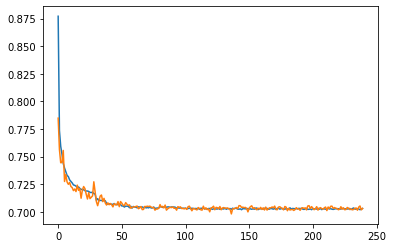

In [7]:
qrnn.save(os.path.expanduser(outputfile))

#qrnn = QRNN.load(os.path.expanduser('~/Dendrite/Projects/IWP/GMI/training_data/try_training/qrnn_gmi_iwp5.nc'))
fig, ax = plt.subplots(1, 1)
ax.plot(results['training_errors'])
ax.plot(results['validation_errors'])

100%|██████████| 625/625 [00:06<00:00, 102.98it/s]


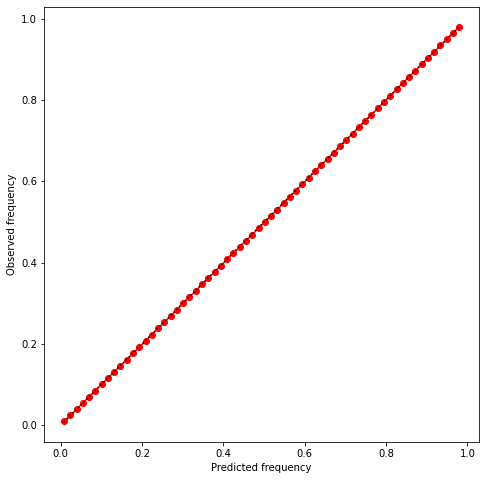

In [8]:
x, y = qrnn.calibration(validation_data)
f, ax = plt.subplots(1, 1, figsize = [8, 8])
ax.plot(x, y, marker = "o", c = 'r')
ax.plot(x, x, ls = ":", c = "k")
#ax.set_xlim([0.1, 0.9])
#ax.set_ylim([0.1, 0.9])
ax.set_aspect(1.0)
ax.set_xlabel("Predicted frequency")
ax.set_ylabel("Observed frequency")
f.savefig("calibration.png", bbox_inches = "tight")

625


Text(0.5, 0, 'IWP[kg/m2]')

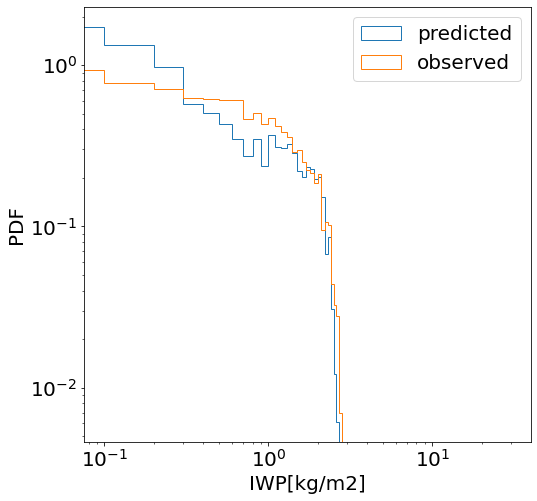

In [9]:
y_pre = []
y = []
y_prior = []
y_pos_mean = []
x_in = []

nbatch = validation_data.__len__()
print (nbatch)
for i in range(nbatch):
    
    xx, yy = validation_data.__getitem__(i)
    
    x = xx.detach().numpy() 

    y_pre.append(qrnn.predict(x)) 
    y_pos_mean.append((qrnn.posterior_mean(x)))
       
    y.append(yy.detach().numpy())
    x_in.append(x)

x_in = np.concatenate(x_in, axis = 0)
y_pre = np.concatenate(y_pre, axis = 0)
y = np.concatenate(y, axis= 0)
y_pos_mean = np.concatenate(y_pos_mean, axis = 0)

plt.rcParams.update({'font.size': 20})
bins1 = np.arange(0, 30, 0.1)
fig, ax = plt.subplots(1, 1, figsize = [8, 8])
ax.hist(y_pos_mean, bins1, density = True , histtype = "step", label = "predicted")


ax.hist(y, bins1, density = True, histtype = "step", label = "observed")
ax.set_yscale('log')
ax.set_xscale('log')

ax.legend()
ax.set_ylabel("PDF")
ax.set_xlabel("IWP[kg/m2]")

In [10]:
y_pre.max()

3.6864161

/home/inderpreet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: Log scale: values of z <= 0 have been masked
  


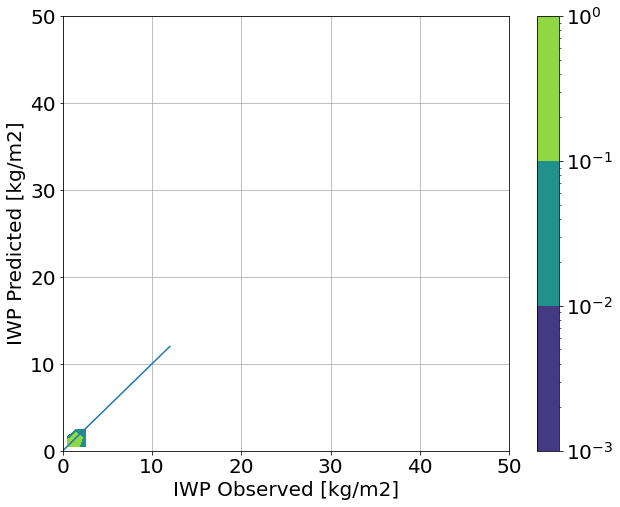

In [11]:
import scipy
from matplotlib import ticker, cm
xyrange = [[0, 50], [0, 50]] # data range

bins = [50, 50] # number of bins
hh, locx, locy = np.histogram2d(y, y_pos_mean, 
                                range=xyrange, bins=bins, density = True)
posx = np.digitize(y, locx)
posy = np.digitize(y_pos_mean, locy)

fig, ax = plt.subplots(1, 1, figsize = [10, 8])
cs = ax.contourf(np.flipud(hh.T),
                extent=np.array(xyrange).flatten(), 
            locator= ticker.LogLocator(), origin='upper')
cbar = fig.colorbar(cs)
ax.set_ylim([0, 50])
ax.set_xlim([0, 50])
xy = np.arange(0, 13, 1)
yy = xy
ax.plot(xy, yy)
ax.set_ylabel("IWP Predicted [kg/m2]")
ax.set_xlabel("IWP Observed [kg/m2]")
ax.grid('on')
#ax.set_yscale('log')
#ax.set_xscale('log')